## Download SQuAD 2.0 dataset and Tranformers library

The ***Stanford Question Answering Dataset*** (SQuAD) consists of questions (100,000)  on a set of Wikipedia articles where the answer to every question is a segment of text, or span, from the corresponding reading passage. In second version of SQuAD unanswerable questions were added (50,000) to look similar to answerable ones.  

The systems using the SQuAD2.0 dataset, must be not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering. 

# LIBRARIES

In [1]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [2]:
!pip install transformers
from transformers import BertForQuestionAnswering, BertTokenizerFast, AdamW
import torch
import math
import time
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import argparse
import collections
import os
import re
import string
import sys

     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 895 kB 58.0 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 6.5 MB 25.5 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# <font color='pink'>LOAD THE FILES from SQUAD 2.0</font>
### TRAIN_SET AND VALIDATION_SET

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd squad

/content/squad


In [5]:
import os
path = os.getcwd()
path

'/content/squad'

In [6]:
#should be in the directory named /content/squad with the colab notebook
file_for_training = "train-v2.0.json"
file_for_testing = "dev-v2.0.json"

In [7]:
# Opening JSON files
training_file = open(file_for_training)
testing_file = open(file_for_testing) 

# return JSON object as a dictionary
training_data = json.load(training_file)
testing_data = json.load(testing_file)

In [8]:
import os
path = os.getcwd()
os.chdir('/content')
path = os.getcwd()


In [9]:
path

'/content'

# PREPROCESS

In [16]:
def JSON_to_DataFrame(data):
  full_data = []
  for general_dict in (data['data']):
    paragraphs = general_dict['paragraphs']    #list of dicts with keys: context, qas
    for paragraph in paragraphs:
      cont_list = []
      context = paragraph['context']
      cont_list.append(context)
      for qas in paragraph['qas']:            #list of dicts with keys: is_impossible, answers, question
        q_list = []
        q_list.append(qas['question'])
        if not qas['is_impossible']:     #if there is an answer provided
          for ans in qas['answers']:           #list of dicts with keys: text, answer_start
            row = []
            row.append(ans['text'])
            row.append(ans['answer_start'])
            row = cont_list + q_list + row + [0]  #we apply 0 as an end_index at the beginning
            full_data.append(row)
        else:     #no answer
          for ans in qas['plausible_answers']:   #list of dicts with keys: text, answer_start
            row = []
            row.append(ans['text'])
            row.append(ans['answer_start'])
            row.append(ans['answer_start'])  #start and end index are the same because there is no answer
            row = cont_list + q_list + row 
            full_data.append(row)

  #create dataframe with the following columns
  COLUMNS = ['context', 'question', 'answer', 'start_index', 'end_index']
  df = pd.DataFrame(full_data, columns = COLUMNS)
  return df


training_df = JSON_to_DataFrame(training_data)
testing_df = JSON_to_DataFrame(testing_data)
# training_csv = training_df.to_csv('training_data.csv')
# test_csv = testing_df.to_csv('testing_data.csv')

In [17]:
#remove duplicate rows 
training_df.drop_duplicates(keep = 'first', inplace=True)
testing_df.drop_duplicates(keep = 'first', inplace=True)

#print some sizes and shapes
print(training_df.shape)
print(testing_df.shape)

(130293, 5)
(16315, 5)
0
0


In [41]:
# #Remove unanswered questions from both training and testing dataframes

#I did not use it after all
# no_answer = training_df[training_df['answer'].isna()]
# training_df = training_df.drop(index = no_answer.index.to_list())

# no_answer = testing_df[testing_df['answer'].isna()]
# testing_df = testing_df.drop(index = no_answer.index.to_list())

In [18]:
#print some sizes and shapes
print(training_df.shape)
print(testing_df.shape)
print(training_df['answer'].isna().sum())   #unanswered questions in training data
print(testing_df['answer'].isna().sum())    #unanswered questions in test data

(130293, 5)
(16315, 5)
0
0


In [43]:
testing_df['context'].str.len().max()

4063

In [44]:
training_df['context'].str.len().max()

3706

In [19]:
#Bert needs also the end_position of an answer except for the start_position
#So, we try to find it
#end position = start_position + len(answer)
#however sometimes the answers provided bz SQUAD do not contain some special characters such as ",', ..
#this leads to different start and end indexes and we try to fix this problem by setting the start-end indexes 
#exactly where the answer starts/ ends

def Add_End_Index(df):
  for index, row in df.iterrows():
    paragraph = row['context']
    # if not pd.isna(row['answer']):
    if row['end_index'] == 0:    #if there is an answer for the question
      squad_answer = row['answer']
      start_index = int(row['start_index'])
      end_index = int(start_index + len(squad_answer))
      start_col = 'start_index'
      end_col = 'end_index'

      if(paragraph[start_index:end_index] == squad_answer):
        df.loc[index, end_col] = end_index
      elif (paragraph[start_index-1:end_index-1] == squad_answer):
        df.loc[index, start_col] = start_index - 1
        df.loc[index, end_col] = end_index - 1
      elif (paragraph[start_index-2:end_index-2] == squad_answer):
        df.loc[index, start_col] = start_index - 2
        df.loc[index, end_col] = end_index - 2
    
  return

In [20]:
Add_End_Index(training_df)
Add_End_Index(testing_df)

# <font color='cyan'>Functions for METRICS</font>

In [ ]:
def Learning_Curve(n_epochs, train_loss, valid_loss):  #create the learning curve
  plt.plot(n_epochs, train_loss, 'm')
  plt.plot(n_epochs, valid_loss, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["training", "validation"], loc ="upper right")
  plt.show()
  return

# TOKENIZE

In [ ]:
#tokenize the sentences
def Tokenize(df, tokenizer, tokens):
  
  paragraphs = df['context'].values.tolist()
  questions = df['question'].values.tolist()
  encodings = tokenizer(paragraphs, questions, max_length = tokens,
                                          add_special_tokens=True,
                                          return_token_type_ids = False, 
                                          truncation=True, padding=True)


  return encodings

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_encodings = Tokenize(training_df, tokenizer, 350)
test_encodings = Tokenize(testing_df, tokenizer, 350)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [74]:
def Convert_to_ints(start, end):

  start_temp = []
  end_temp = []
  for num in start:
    num = int(num)
    start_temp.append(num)
  for num in end:
    num = int(num)
    end_temp.append(num)

  start = start_temp
  end = end_temp  
  return start, end


In [75]:
train_start = training_df['start_index'].values.tolist()
train_end = training_df['end_index'].values.tolist()

test_start = testing_df['start_index'].values.tolist()
test_end = testing_df['end_index'].values.tolist()

# train_start, train_end  = Convert_to_ints(train_start, train_end)
# test_start, test_end  = Convert_to_ints(test_start, test_end)

In [ ]:
def add_token_positions(encodings, start_indexes, end_indexes):
    start_positions = []
    end_positions = []
    for i in range(len(start_indexes)):
      if start_indexes[i] >= 0:
          start_positions.append(encodings.char_to_token(i, start_indexes[i]))
        #we apply end_index-1 for he end position because eg word_length = 10
        #the indexes are 0 - 9
      if end_indexes[i] >= 0:
          end_positions.append(encodings.char_to_token(i, end_indexes[i] - 1)) 

      # if start position is None, the answer passage has been truncated
      if start_positions[-1] is None:          
          start_positions[-1] = tokenizer.model_max_length
      # if end position is None, the answer passage has been truncated or we have the answer until 
      # a specific word so we set the end_index as the max_length of the sequence
      if end_positions[-1] is None:
          end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

    return
add_token_positions(train_encodings, train_start, train_end)
add_token_positions(test_encodings, test_start, test_end)

# DATASET

In [57]:
class SQUAD_Dataset(Dataset):

  def __init__(self, encodings):
    self.encodings = encodings

  def __len__(self):
    return len(self.encodings.input_ids)

#return every paragraph - question as a dict of encoded values in tensors 
#the keys are: input_ids (encoded_tokens), attention_mask, start_positions (where the answer starts), end_positions (where the answer ends)
  def __getitem__(self, index):
    
    t0 = torch.tensor(self.encodings['input_ids'][index])
    t1 = torch.tensor(self.encodings['attention_mask'][index])
    t2 = torch.tensor(self.encodings['start_positions'][index])
    t3 = torch.tensor(self.encodings['end_positions'][index])

    return t0, t1, t2, t3


In [27]:
#tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_set = SQUAD_Dataset(train_encodings)
test_set = SQUAD_Dataset(test_encodings)

In [ ]:
print(len(train_set), len(test_set))

86798 10386


# BERT BASE MODEL

In [10]:
class Q_A(nn.Module):
  def __init__(self, max_tokens=512):
    super(Q_A, self).__init__()
    self.bert_model = BertForQuestionAnswering.from_pretrained('bert-base-uncased', output_hidden_states=False, output_attentions =False) 




  def forward(self, input_ids, attention_mask, start, end):


    out = self.bert_model(input_ids = input_ids, attention_mask = attention_mask,
                     start_positions = start, end_positions = end, return_dict = False)
    # print(out)
    # out  -> loss, start_logits, end_logits, hidden_states, attention
    return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# <font color='orange'>TRAINING EVALUATION </font>

In [ ]:
def train(model, device, dataloader, batch_size, optimizer):    #otan kalestei ->target auto training_df['label']
  
  model.train()

  batch_losses = []

  # for el1, el2, el3, el4 in dataloader:
  i = 0
  for x1_train_batch, x2_train_batch, x3_train_batch, x4_train_batch in dataloader:  
    if(i%100 == 0):
      print("Train batch ", i)
    i+=1

    x1_train_batch = x1_train_batch.to(device)
    x2_train_batch = x2_train_batch.to(device)
    x3_train_batch = x3_train_batch.to(device)
    x4_train_batch = x4_train_batch.to(device)

    #Delete previously stored gradients
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      output = model(x1_train_batch, x2_train_batch, x3_train_batch, x4_train_batch)
      #calculate loss
      loss = output[0]
      batch_losses.append(loss.item())
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()

      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()


  epoch_loss = sum(batch_losses) / len(dataloader)
  return epoch_loss 



def evaluate(model, device, dataloader, batch_size):
    
    model.eval()
    batch_losses = []
    i = 0
    
    for x1_valid_batch, x2_valid_batch, x3_valid_batch, x4_valid_batch in dataloader:
      if(i%100 == 0):
        print("Valid batch ", i)
      i+=1

      x1_valid_batch = x1_valid_batch.to(device)
      x2_valid_batch = x2_valid_batch.to(device)
      x3_valid_batch = x3_valid_batch.to(device)
      x4_valid_batch = x4_valid_batch.to(device)     
      
      with torch.no_grad():
        #evaluate
        output = model(x1_valid_batch, x2_valid_batch, x3_valid_batch, x4_valid_batch)
        # print(output)
        #calculate loss
        loss = output[0]
        batch_losses.append(loss.item())
    
    epoch_loss = sum(batch_losses) / len(dataloader)
    return epoch_loss

In [ ]:
def Train_Evaluate_TheModel(model, epochs, batch_size, optimizer, device, train_set, valid_set):
  
  train_epoch_losses = []
  valid_epoch_losses = []
  train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = False) #Training set
  valid_dataloader = DataLoader(valid_set, batch_size = batch_size, shuffle = False) #Validation set


  total_time = time.time()
  for epoch in range(epochs):
    epoch_time = time.time()
    train_loss = train(model, device, train_dataloader, batch_size, optimizer)
    eval_loss = evaluate(model, device, valid_dataloader, batch_size)
    
    train_epoch_losses.append(train_loss)
    valid_epoch_losses.append(eval_loss)

    print(f"Epoch {epoch:3}: Training Loss = {train_loss:.5f}")
    print(f"Epoch {epoch:3}: Validation Loss = {eval_loss:.5f}")
    print(f"Epoch Time = {time.time() - epoch_time}")
    if epoch==0:
      best_loss = eval_loss
    elif eval_loss < best_loss:
      best_loss = eval_loss


  print(f"Total Time = {time.time() - total_time}")
  return train_epoch_losses, valid_epoch_losses

# <font color = 'red'>EVALUATION SCRIPT FROM STANFORD for the calculation of EM and F1 SCORES</font>

In [ ]:
"""Official evaluation script for SQuAD version 2.0."""

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1


# EXECUTE

## 1 - lr = 5e-5, max_tokens = 512, batch_size = 8

For larger batch sizes I was almost always left out of RAM. I stopped the process after the first 1000 batches out of total 10000,  because it was obvious that the model would take too long to be trained. For the first 1000 batches it needed 25 min, so we can infer that for 10000 batches it will need 250 min almost 4 hours ONLY for 1 epoch. 

You can see the message "KeyboardInterrupt:"

In [ ]:
learning_rate = 5e-5

bert_qa_model = Q_A().to(device)
optimizer = AdamW(bert_qa_model.parameters(), lr=0.0001, weight_decay=1e-4)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses = Train_Evaluate_TheModel(bert_qa_model, 3, 8, 
                                                                 optimizer,  device, train_set, test_set)

Train batch  0
Train batch  100
Train batch  200
Train batch  300
ok3
ok4
ok3
ok4
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000
Train batch  1100


KeyboardInterrupt: ignored

## 2 - lr = 5e-5, max_tokens = 256, batch_size = 8

I reduced the number of tokens for every sequence (paragraph and question) at 256. I kept batch_size at 8, because for larger batch sizes I was almost always  left out of RAM.

Same as above; I stopped the process after the first 1000 batches out of total 10000,  because it was obvious that the model would take too long to be trained. For the first 1000 batches it needed 25 min, so we can infer that for 10000 batches it will need 250 min almost 4 hours ONLY for 1 epoch. 

You can see the message "KeyboardInterrupt:"

In [ ]:
learning_rate = 5e-5

bert_qa_model = Q_A(256).to(device)
optimizer = AdamW(bert_qa_model.parameters(), lr=0.0001, weight_decay=1e-4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses = Train_Evaluate_TheModel(bert_qa_model, 3, 8, 
                                                                 optimizer,  device, train_set, test_set)

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000
Train batch  1100


KeyboardInterrupt: ignored

## 3 - lr = 5e-5, max_tokens = 150, batch_size = 8

I reduced the number of tokens for every sequence (paragraph and question) at 150. I kept batch_size at 8, because for larger batch sizes I was almost always  left out of RAM (again).

Same as above; I stopped the process after the first 1000 batches out of total 10000,  because it was obvious that the model would take too long to be trained. For the first 1000 batches it needed 25 min, so we can infer that for 10000 batches it will need 250 min almost 4 hours ONLY for 1 epoch. 

You can see the message "KeyboardInterrupt:"

In [ ]:
learning_rate = 5e-5

bert_qa_model = Q_A(150).to(device)
optimizer = AdamW(bert_qa_model.parameters(), lr=0.0001, weight_decay=1e-4)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses = Train_Evaluate_TheModel(bert_qa_model, 3, 8, 
                                                                 optimizer,  device, train_set, test_set)

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000


KeyboardInterrupt: ignored

## 4 - lr = 5e-5, max_tokens = 120, batch_size = 8

I reduced the number of tokens for every sequence (paragraph and question) at 150. I kept batch_size at 8, because for larger batch sizes I was almost always  left out of RAM (again).

Same as above; I stopped the process after the first 1000 batches out of total 10000,  because it was obvious that the model would take too long to be trained. For the first 1000 batches it needed 25 min, so we can infer that for 10000 batches it will need 250 min almost 4 hours ONLY for 1 epoch. 

You can see the message "KeyboardInterrupt:"

In [ ]:
learning_rate = 5e-5

bert_qa_model = Q_A(120).to(device)
optimizer = AdamW(bert_qa_model.parameters(), lr=0.0001, weight_decay=1e-4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses = Train_Evaluate_TheModel(bert_qa_model, 3, 8, 
                                                                 optimizer,  device, train_set, test_set)

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000


KeyboardInterrupt: ignored

## 5 - OUT OF CUDA so I used Kaggle with lr = 5e-5, max_tokens = 350, batch_size = 16

I reduced the number of tokens for every sequence (paragraph and question) at 350. I kept batch_size at 16. I decided to keep the values for all hyperparameters on average levels so that I will not be left out RAM again.

Kaggle's GPU seemed to be better, since I needed only 4 hours for training and evaluating the model for 3 epochs.

In [ ]:
learning_rate = 5e-5

bert_qa_model = Q_A(350).to(device)
optimizer = AdamW(bert_qa_model.parameters(), lr=0.0001, weight_decay=1e-4)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#TRAIN AND EVALUATE THE MODEL  - 4 hours for 3 epochs
train_epoch_losses, valid_epoch_losses = Train_Evaluate_TheModel(bert_qa_model, 3, 16, 
                                                                 optimizer,  device, train_set, test_set)

Train batch  0
Train batch  100
Train batch  200
Train batch  300
Train batch  400
Train batch  500
Train batch  600
Train batch  700
Train batch  800
Train batch  900
Train batch  1000
Train batch  1100
Train batch  1200
Train batch  1300
Train batch  1400
Train batch  1500
Train batch  1600
Train batch  1700
Train batch  1800
Train batch  1900
Train batch  2000
Train batch  2100
Train batch  2200
Train batch  2300
Train batch  2400
Train batch  2500
Train batch  2600
Train batch  2700
Train batch  2800
Train batch  2900
Train batch  3000
Train batch  3100
Train batch  3200
Train batch  3300
Train batch  3400
Train batch  3500
Train batch  3600
Train batch  3700
Train batch  3800
Train batch  3900
Train batch  4000
Train batch  4100
Train batch  4200
Train batch  4300
Train batch  4400
Train batch  4500
Train batch  4600
Train batch  4700
Train batch  4800
Train batch  4900
Train batch  5000
Train batch  5100
Train batch  5200
Train batch  5300
Train batch  5400
Train batch  5500
Trai

In [ ]:
def Learning_Curve(n_epochs, train_loss, valid_loss):  #create the learning curve
  plt.plot(n_epochs, train_loss, 'm')
  plt.plot(n_epochs, valid_loss, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["training", "validation"], loc ="upper right")
  plt.show()
  return

In [ ]:
print(train_epoch_losses)
print(valid_epoch_losses)

[1.5809272792490385, 1.2115029306205864, 1.0317728189080917]
[1.7290530066864163, 1.7644880160689353, 1.8720065723739419]


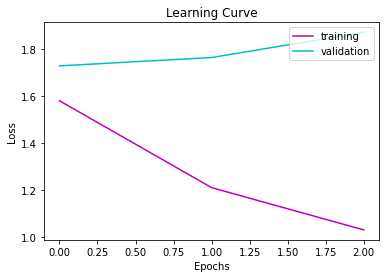

In [ ]:
epochs = np.arange(0, 3).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

# Save the model 

In [ ]:
# Save model
torch.save(bert_qa_model.state_dict(),"/content/drive/MyDrive/QA_BERT_FineTuned")

In [30]:
# Load the fine-tuned model
qa_bert_model = Q_A()
qa_bert_model.load_state_dict(torch.load("/content/drive/MyDrive/QA_BERT_FineTuned",map_location=torch.device(device)))


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

<All keys matched successfully>

# EVALUATION - EM F1 scores on SQUAD 2.0

In [15]:
class Sentence_Dataset(Dataset):

  def __init__(self, encodings):
    self.encodings = encodings

  def __len__(self):
    return len(self.encodings.input_ids)

#return every paragraph - question as a dict of encoded values in tensors 
#the keys are: input_ids (encoded_tokens), attention_mask, start_positions (where the answer starts), end_positions (where the answer ends)
  def __getitem__(self, index):
    
    t0 = torch.tensor(self.encodings['input_ids'][index])
    t1 = torch.tensor(self.encodings['attention_mask'][index])
    t2 = torch.tensor(self.encodings['start_positions'])
    t3 = torch.tensor(self.encodings['end_positions'])
    return t0, t1, t2, t3


In [23]:
def Evaluate_EM_F1(model, device, test_df, tokenizer):

  model.eval()
  total_sentences = len(test_df)
  EM_sentences = 0
  f1_score_list = []
  total_f1_score = 0.0
  index = -1
  start_indexes = testing_df['start_index'].values.tolist()
  end_indexes = testing_df['end_index'].values.tolist()
  input_ids = None
  for i, row in testing_df.iterrows():
    empty = False
    index += 1
    context = row['context']
    question = row['question'] 
    if (row['start_index'] == row['end_index']):   #no answer for this question
      true_answer = ''
      empty = True
    else:
      true_answer = row['answer']

    encoded_input = tokenizer.encode_plus(question, context, add_special_tokens=True,
                                              return_token_type_ids = False, 
                                              padding = 'max_length', truncation=True, return_attention_mask = True, 
                                              return_tensors='pt')
    
    if row['start_index'] >= 0:
        start_position = encoded_input.char_to_token(row['start_index'], sequence_index =1)
      #we apply end_index-1 for he end position because eg word_length = 10
      #the indexes are 0 - 9
    if row['end_index'] >= 0:
        end_position = encoded_input.char_to_token(row['end_index'], sequence_index =1)
    # if start position is None, the answer passage has been truncated
    if start_position is None:          
        start_position = tokenizer.model_max_length
    # if end position is None, the answer passage has been truncated or we have the answer until 
    # a specific word so we set the end_index as the max_length of the sequence
    if end_position is None:
        end_position = tokenizer.model_max_length

    encoded_input.update({'start_positions': start_position, 'end_positions': end_position})


    test_set = Sentence_Dataset(encoded_input)
    dataloader = DataLoader(test_set, batch_size = 1) #Validation set

    for x1_test_batch, x2_test_batch, x3_test_batch, x4_test_batch in dataloader:

      x1_test_batch = x1_test_batch.detach().clone().to(device)   #input ids
      x2_test_batch = x2_test_batch.detach().clone().to(device)   #attention mask
      x3_test_batch = x3_test_batch.to(device)   #start positions
      x4_test_batch = x4_test_batch.to(device)   #end positions  
      
      with torch.no_grad():
        #evaluate
        output = model(x1_test_batch, x2_test_batch, x3_test_batch, x4_test_batch)

        pred_start = torch.argmax(output[1], dim=1)  # get the most likely beginning of answer with the argmax of the score
        pred_end = torch.argmax(output[2], dim=1) 

        x1_test_batch = x1_test_batch.squeeze().tolist()

        if not empty:
          predicted_tokens = tokenizer.convert_ids_to_tokens(x1_test_batch[pred_start:pred_end+1]) 
        else:
          predicted_tokens = tokenizer.convert_ids_to_tokens(x1_test_batch[pred_start:pred_end])
        predicted_answer = tokenizer.convert_tokens_to_string(predicted_tokens)

        EM_sentences += compute_exact(true_answer, predicted_answer)
        f1_score = compute_f1(true_answer, predicted_answer)

        f1_score_list.append(f1_score)


    
  return EM_sentences, f1_score_list

In [ ]:
EM, F1 = Evaluate_EM_F1(qa_bert_model, device, testing_df, tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
print("Correct sentences ", EM, " out of ", len(testing_df))
print("F1 score for the whole dataset Squad 2.0 is: ", sum(F1)/len(testing_df))

Correct sentences  5668  out of  16315
F1 score for the whole dataset Squad 2.0 is:  0.46529454583144636
